# Intro

Time series is a fairly popular data structure that almost everyone sooner or later has to work with. Due to the features of these tasks, there were invented many specific ways of analyzing, modeling, and forecasting time series. Despite this, many researchers still prefer to use classical Machine Learning algorithms, such as gradient boosting, on fairly primitive features. Therefore, in this study I want to find out whether it makes sense to study a new approach to the problem, and in which cases the use of specialized models is justified. To do this, we will analyze the time series and predict it using several techniques (including statistical models, boosting, and neural networks)

# 1 Dataset we are working with

We will work with a Kaggle dataset (https://www.kaggle.com/datasets/htagholdings/property-sales). It shows sales of different property from 2007 to 2019, and the interesting thing is that there are several features, so
target depends not only on time. In this notebook I want to analyze the dataset and to do simple feature engineering, hence, we will be able to do forecasting after that

### 1.0 Important thing before we start

I would like to pay attention to one detail. By definition, a time series is a time-varying observation of one object with a certain periodicity. Here we have different characteristics of objects (for example, different houses have different numbers of rooms). That is, it is more like panel data (if we assume that houses with the same characteristics are the same houses). Usually panel data is considered separately in econometrics, while in Machine Learning those types of problems are usually still attributed to time series tasks. However, due to the specifics of the data structure, we will not be able to use some time series methods. For example, the ARMA process:

$$\text{ARMA}(p, q): y_t = c + \sum_{i=1}^{p}\alpha_iy_{t-i} + \sum_{i=1}^{q}\beta_i \epsilon_{t-i} + \epsilon_t$$

does not make big sense here, because it does not take into account features of data, rather than lags. Of course, we assume other features to explain target quite well (it seems reasonable that the more rooms the house has, the more it costs (other things being equal)). Hence, I expect classical Machine Learning algorithms to perform very well (or at least better) here. In fact, this is one of the many reasons why they are preferred by many in time series prediction problems. Sometimes we are already given or at least try to generate additional features, which we can easily use in models like GBM

### 1.1 Very basic things

Let's see the data we are working with (number of features and observations, and so on) in order to get a basic understanding of a problem is and how to solve it

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 18

In [2]:
df = pd.read_csv('raw_sales.csv')
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


In [5]:
df['bedrooms'].value_counts()

3    11933
4    10442
2     3598
5     1950
1     1627
0       30
Name: bedrooms, dtype: int64

It seems weird that we have observations with 0 bedrooms. Since there are not many of them, we can take a closer look and compare their prices with the average price

In [6]:
df['price'].mean()

609736.262204192

In [7]:
df.loc[df['bedrooms'] == 0]

,datesold,postcode,price,propertyType,bedrooms
5801,2012-09-10 00:00:00,2913,415000,house,0
6484,2013-02-02 00:00:00,2605,840000,house,0
6497,2013-02-06 00:00:00,2604,490000,house,0
6917,2013-05-07 00:00:00,2600,725000,house,0
7167,2013-06-28 00:00:00,2606,630000,house,0
7284,2013-07-18 00:00:00,2602,620000,house,0
7460,2013-08-17 00:00:00,2617,543000,house,0
10522,2014-12-03 00:00:00,2615,405000,house,0
10792,2015-01-27 00:00:00,2906,525000,house,0
10819,2015-01-31 00:00:00,2602,700000,house,0


At least most of these observations look fine. Let's substitute 0 bedrooms with the value of 1

In [8]:
df.loc[df['bedrooms'] == 0, 'bedrooms'] = 1

In [9]:
df['postcode'].value_counts()

2615    3566
2602    2603
2913    2558
2905    2259
2617    2115
2914    1972
2611    1864
2906    1640
2612    1210
2604    1058
2614    1058
2902    1035
2607     963
2904     919
2603     805
2605     771
2903     675
2606     659
2600     634
2912     499
2601     260
2911     249
2900     152
2620      26
2616      11
2609      10
2618       9
Name: postcode, dtype: int64

In [10]:
df['propertyType'].value_counts()

house    24552
unit      5028
Name: propertyType, dtype: int64

As we see, we do not have much data. Number of rows is around 30 000, and besides time there are just 3 features, two of which are categorical, and the last one is binary. Also the dataset is imbalanced with respect to features (for example, houses are seen 5 times more often than the units). This means it might be a bad idea to use complex neural network architectures, such as LSTM, since it is likely to overfit on a small amount of data. On the other hand, there is not much information in the features. That is why algorithms like GBM or other popular Machine Learning methods might overfit as well by studying the noise in the data. Hence, probably a good idea is to use special statistical methods to solve the problem of predicting the time series (although my prior belief is that boosting with good regularization is likely to perform better)

### 1.2 Data analysis and simple feature engineering

Now we want to study the data more deeply. We will start by converting datesold to datetime format

In [11]:
df.datesold = pd.to_datetime(df.datesold)
df = df.set_index('datesold')
df

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-07,2607,525000,house,4
2007-02-27,2906,290000,house,3
2007-03-07,2905,328000,house,3
2007-03-09,2905,380000,house,4
2007-03-21,2906,310000,house,3
...,...,...,...,...
2019-07-25,2900,500000,unit,3
2019-07-25,2612,560000,unit,2
2019-07-26,2912,464950,unit,2


Let's see how data is distributed over years

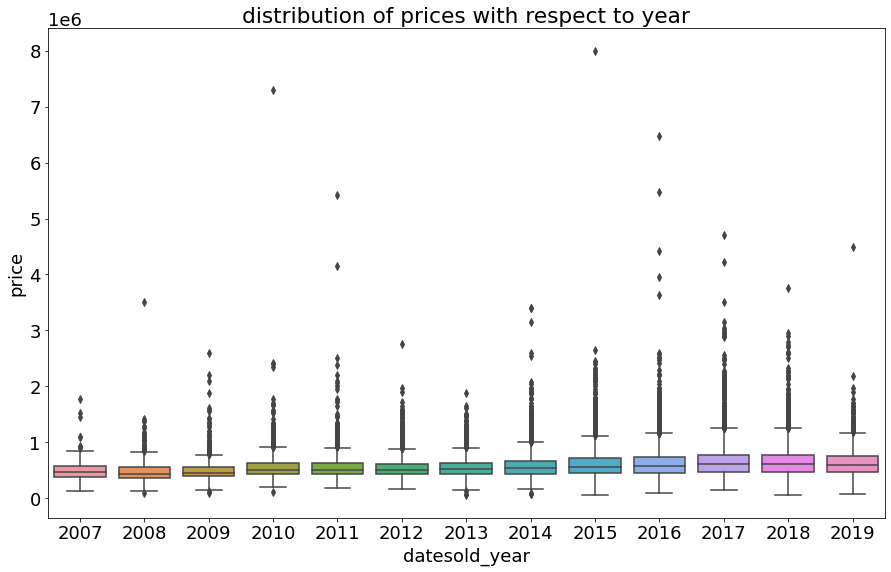

In [12]:
df['datesold_year'] = df.index.year
sns.boxplot(x= 'datesold_year', y = 'price', data=df)
plt.title('distribution of prices with respect to year')
plt.show()

As we see, there are many outliers. Due to this, let's put a limit on target to see the data more clearly

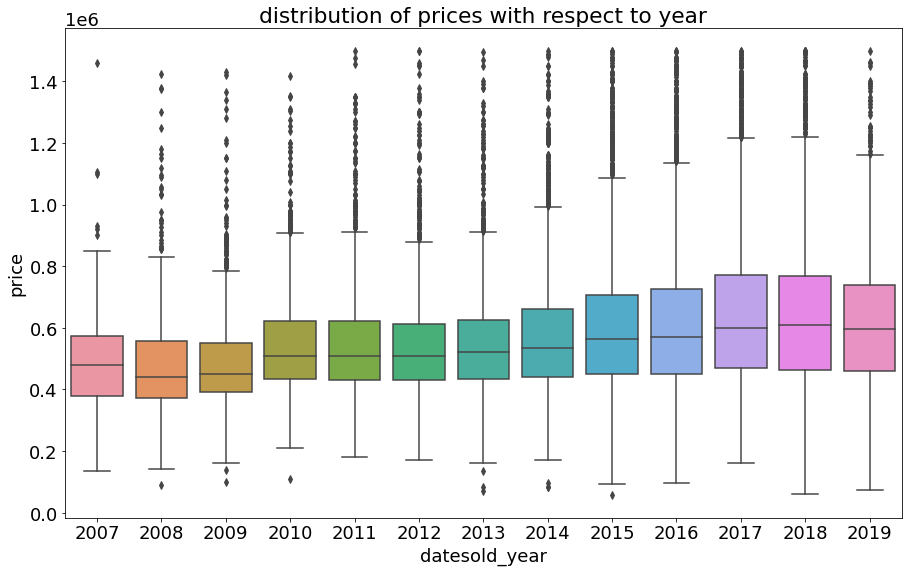

In [13]:
df1 = df.copy()
df1 = df1.loc[df1['price'] <= 1.5e6]
sns.boxplot(x= 'datesold_year', y = 'price', data=df1)
plt.title('distribution of prices with respect to year')
plt.show()

Although there is an upward trend, it seems to me it is not very high, so our time series might be stationary (we will check it soon). Due to many outliers, it seems to be 
reasonable to smooth the target. We will do a 99th and 1st percentiles substitution approach

In [14]:
df.price.describe([.001,.01, .05, .1, .25, .5, .75, .9, .95, .99, .999])

# I think 2e5 is fine for lower limit, and 99th percentile - for upper

count    2.958000e+04
mean     6.097363e+05
std      2.817079e+05
min      5.650000e+04
0.1%     1.695790e+05
1%       2.510000e+05
5%       3.250000e+05
10%      3.700000e+05
25%      4.400000e+05
50%      5.500000e+05
75%      7.050000e+05
90%      8.925000e+05
95%      1.085000e+06
99%      1.610000e+06
99.9%    2.748420e+06
max      8.000000e+06
Name: price, dtype: float64

In [15]:
upper = df.price.quantile(0.99)
lower = 2e5

df['price'] = df['price'].clip(lower=lower, upper=upper)

Now let's check the distribution of prices. Probably, it will be skewed to the right

Text(0.5, 1.0, 'Distribution of prices overall')

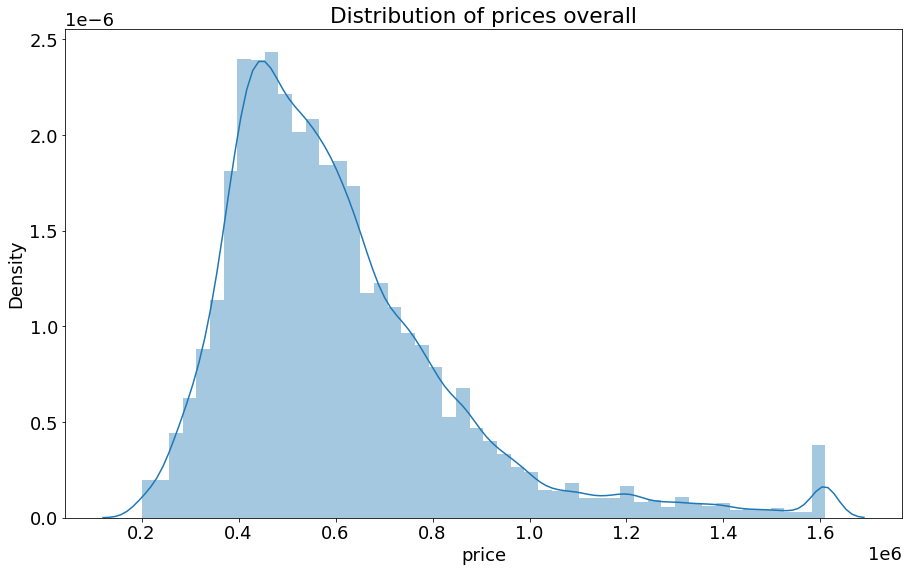

In [16]:
sns.distplot(df['price'])
plt.ylabel('Density')
plt.title('Distribution of prices overall')

Well, it is not so bad. Nevertheless, I suggest to take a logarithm of the target

Text(0.5, 1.0, 'Distribution of prices overall')

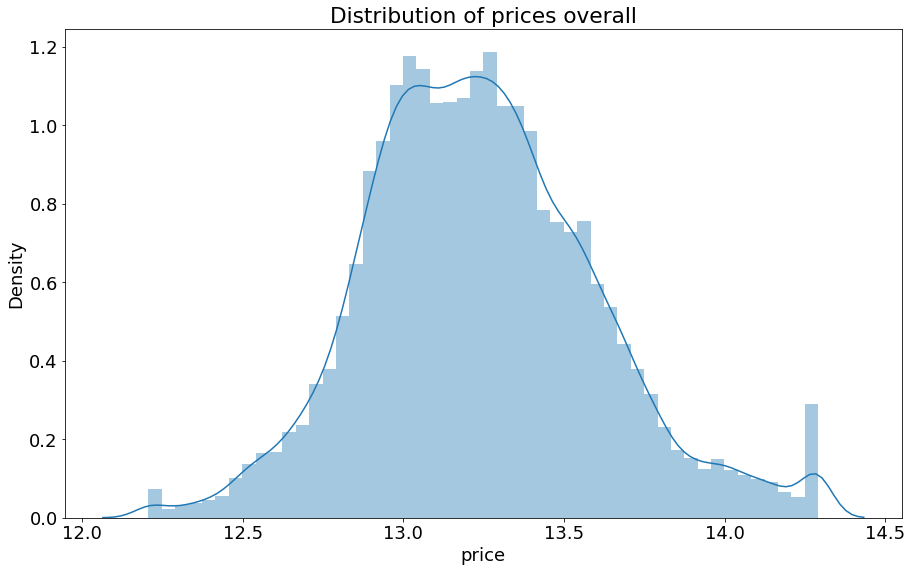

In [17]:
df['price'] = np.log(df['price'])
sns.distplot(df['price'])
plt.ylabel('Density')
plt.title('Distribution of prices overall')
# Now I am satisfied with it

Looks like we are done with feature engineering. Now let's take a look at the distributions of categorical features and how they affect the target

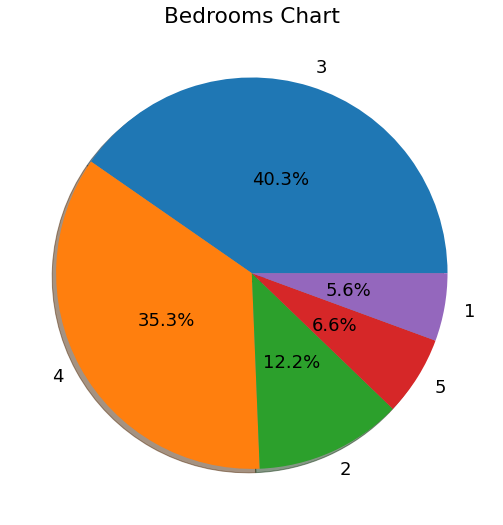

In [18]:
bedrooms_percentage = df['bedrooms'].value_counts()
ax = plt.subplots()
ax = plt.pie(x=bedrooms_percentage, autopct="%.1f%%", labels=df['bedrooms'].value_counts().keys(), pctdistance=0.5,shadow=True )
ax = plt.title('Bedrooms Chart')
plt.show()
# 75% of the time we are dealing with big houses

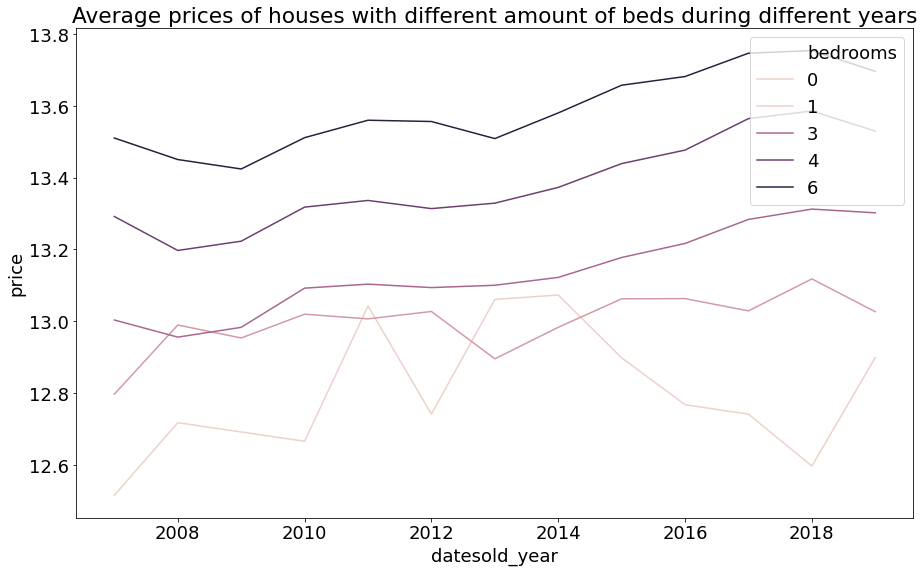

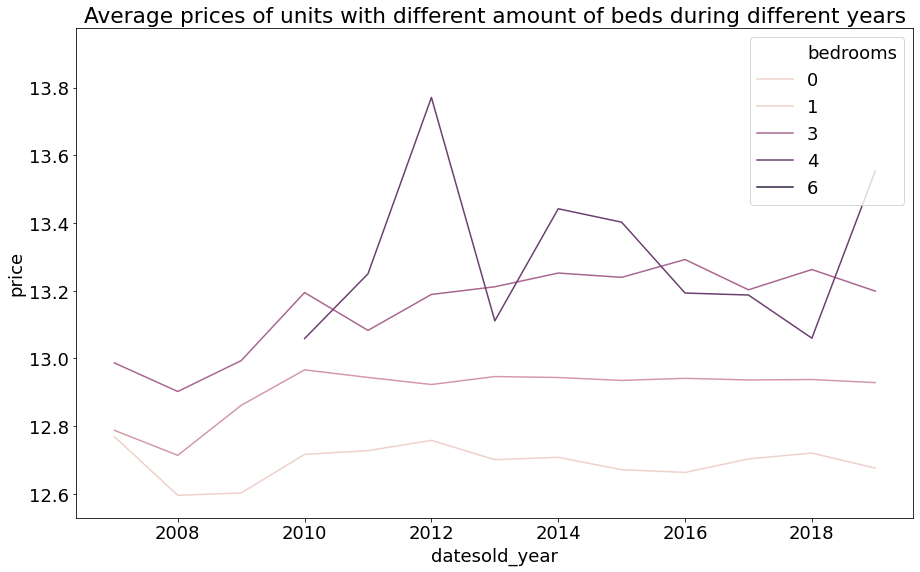

In [19]:
df_viz = df.copy().reset_index()
df_viz = df_viz.groupby(['propertyType', 'datesold_year', 'bedrooms'])['price'].agg('mean').reset_index()

sns.lineplot(data = df_viz.query('propertyType == "house"'), x = 'datesold_year', y = 'price', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.title('Average prices of houses with different amount of beds during different years')
plt.show()

sns.lineplot(data = df_viz.query('propertyType == "unit"'), x = 'datesold_year', y = 'price', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.title('Average prices of units with different amount of beds during different years')
plt.show()

For houses average prices are higher, and for 3+ number of bedrooms we see a clear upward trend. As for units, the range is a bit lower, and for small number of bedrooms we see that overall the series does not change much

# 2 Time Series analysis

So far we were doing very simple analysis. Now I want to focus on more advanced one. We will explore the time series itself by looking at the correlation and seeing, whether it is stationary or not. This will help us get useful insights about the problem and possible ways to solve it

### 2.1 Сhecking if the dataset is stationary

Stationarity is a very useful property. If the time series is stationary, we have more options in terms of predicting it, and we can also have more confidence in our predictions. This is because non-stationary time series typically require more complex models that are harder to interpret and more likely to overfit. In addition, many of the statistical tests that are used to test hypotheses assume that the time series is stationary. Therefore, if the series is not stationary, we cannot rely on these tests.

Even though checking stationarity on the entire dataset may not be the right solution, since, as I said, we have panel data, we will do it anyway.

To keep it simple, stationarity means constant expectation, variance, and covariance over time. So, suppose we have a finite time series that we observe n times: $y_1, y_2, ..., y_n$. Time series is stationary, if:

$$E(y_i) = E(y_j); \text{Var}(y_i) = \text{Var}(y_j) \; \forall i, j; \; \text{Cov}(y_{t + h}, y_{s + h}) = \text{Cov}(y_t, y_s) \; \forall h>0, t, s.$$

Intuitively, this means that the time series oscillates around a single point, and does not go far from it. A good and simple example is the white noise, taken from standard normal distribution:

$$\text{WN} \sim N(0, 1).$$

Since all components are i.i.d, the series is stationary. An example of a non-stationary time series is random walk, where each observation is a previous observation plus a constant and a random noise:

$$\text{RW}: y_{t+1} = a + y_t + \epsilon_t$$

##### 2.1.1 Example of white noise

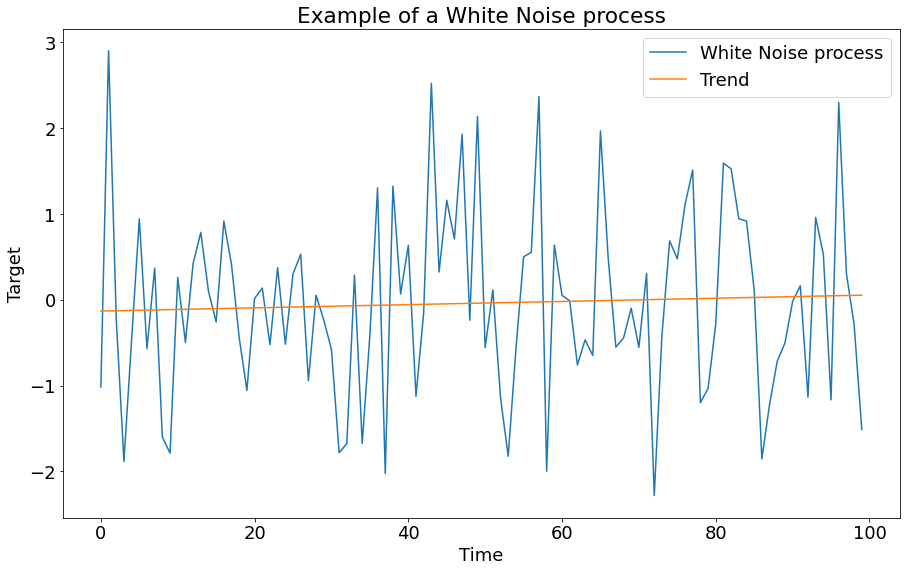

In [20]:
from sklearn.linear_model import LinearRegression

# Plotting white noise
white_noise_process = np.random.normal(0, 1, 100)
plt.plot(white_noise_process, label='White Noise process')

# Adding trens line
time = np.arange(100)
regression = LinearRegression().fit(time.reshape(-1, 1), white_noise_process)
trend_line = regression.predict(time.reshape(-1, 1))
plt.plot(trend_line, label='Trend')
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Example of a White Noise process')
plt.legend()

##### 2.1.2 Example of random walk

No handles with labels found to put in legend.


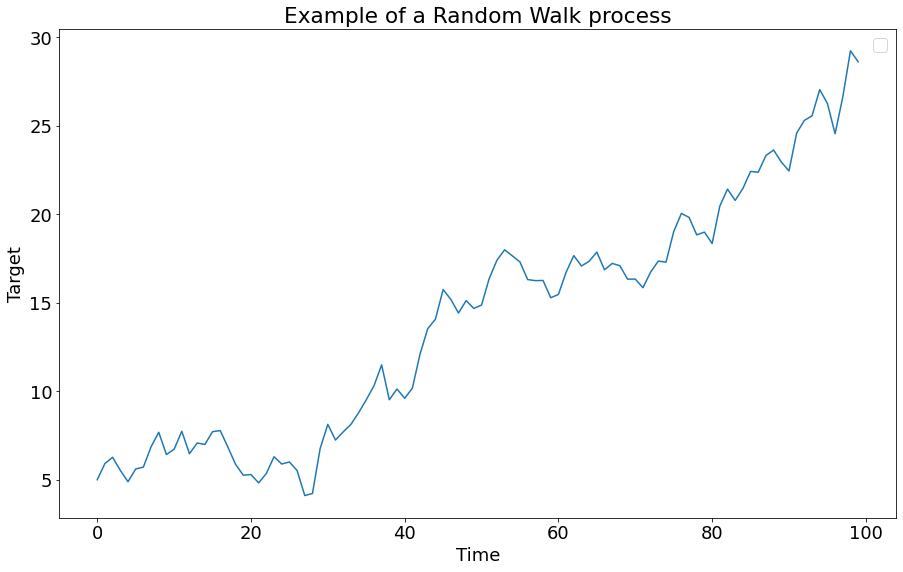

In [21]:
a = 0.3
noises = np.random.normal(0, 1, 100)

random_walk_process = np.empty(100)
random_walk_process[0] = 5
for t in range(1, 100):
    random_walk_process[t] = a + random_walk_process[t-1] + noises[t]
    
plt.plot(random_walk_process)
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Example of a Random Walk process')
plt.legend()

##### 2.1.3 Check the stationarity of our process

Text(0.5, 1.0, 'The change of target overtime')

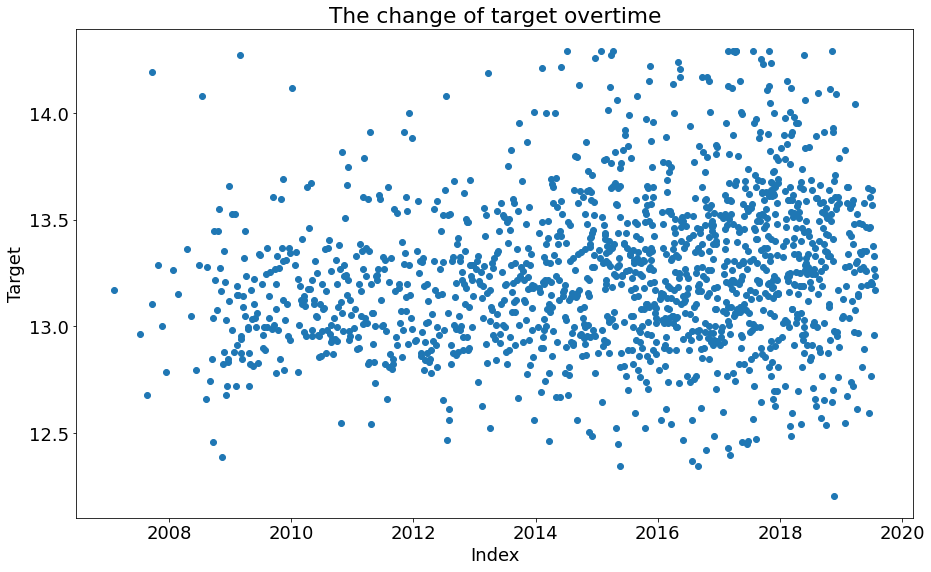

In [22]:
prices = df.price[::20]
indices = df.index[::20]

plt.scatter(indices, prices)
plt.xlabel('Index')
plt.ylabel('Target')
plt.title('The change of target overtime')

From here we see that probably time series is not stationary, since, even though the mean might look as nearly constant, the varience probably is not. However, it is better to apply a special statistical test. We will apply an AD-Fuller test, where null hypothesis is that the series is not stationary and has time dependent structure

In [23]:
from statsmodels.tsa.stattools import adfuller
prices = df.price
result = adfuller(prices)
p_value = result[1]
print(p_value)
p_value < 0.05

1.4601223376262493e-11


True

Well, the test shows that we reject null hypothesis at 5% significance level (and on 1% as well). Despite that, we see that there is still a small upward trend (which seems reasonable in case of property). However, we can feel free to apply all the methods and use statistical tests that are suitable for stationary time series

### 2.2 Autocorrelation analysis

Since our dataset is stationary, we get more options to analyze it. One of them is the computation and interpretation of ACF and PACF

##### 2.2.1 Difference between ACF and PACF

Suppose we want to find the correlation between $y_t$, and $y_{t-2}$ (figure out how target two time periods ago affects current target). There are two approaches to do so:

Direct approach: $y_{t-2} \rightarrow y_t$;

Indirect approach: $y_{t-2} \rightarrow y_{t-1} \rightarrow y_t$

The second one is easier to calculate, while the first one might be more useful, since we do not take into account intermediate steps between those two terms

##### Note that it does not make sense to plot ACF and PCAF graphs on the whole dataset, since target depends not only on time.  We have different number of bedrooms, different property types, and postcodes, so let's group dataset by these terms and months to see the changes in mean prices within that groups. After that, we will plot ACF and PACF graphs for random combinations of features to see if we can find some interesting observations 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


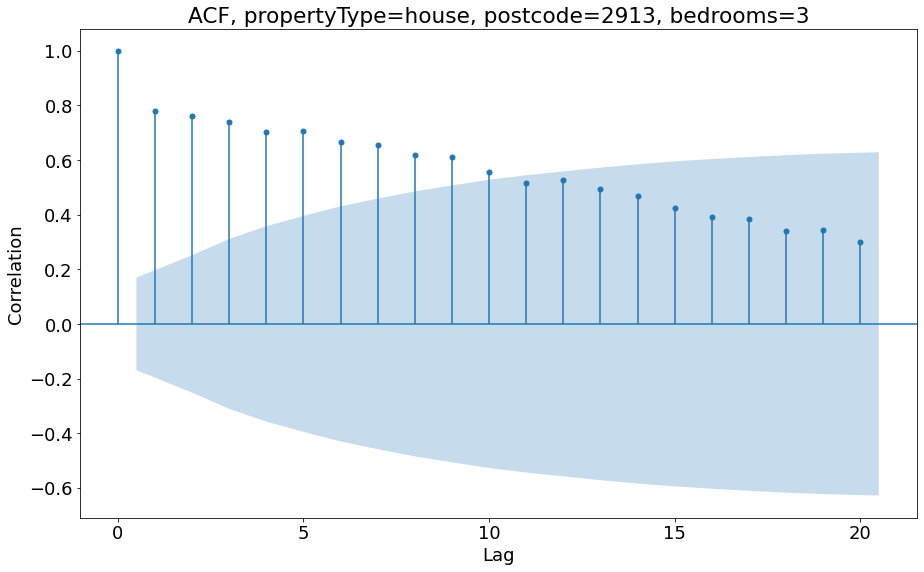

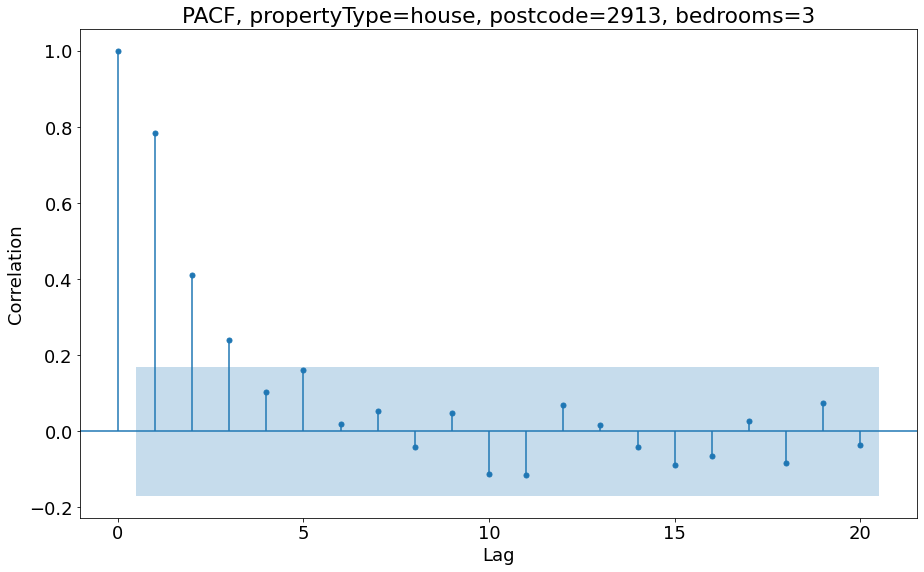

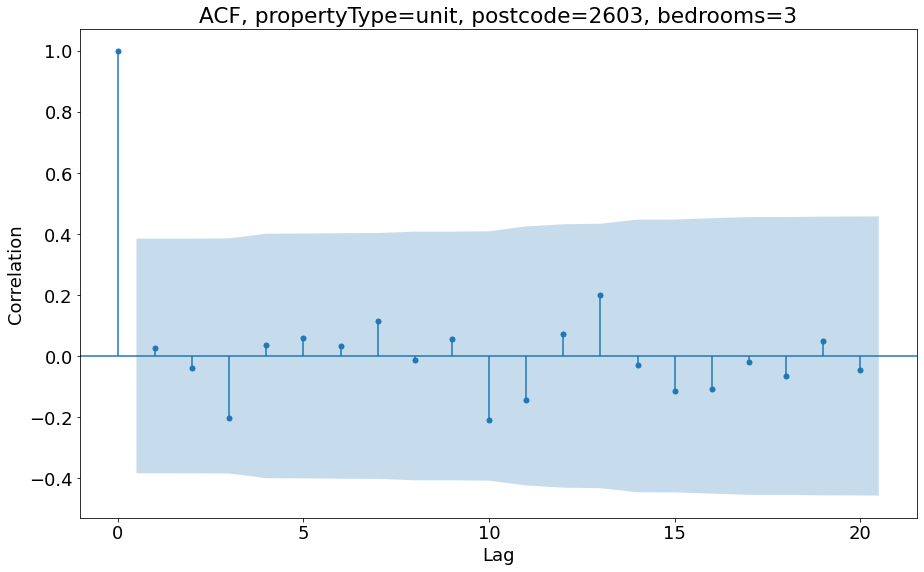

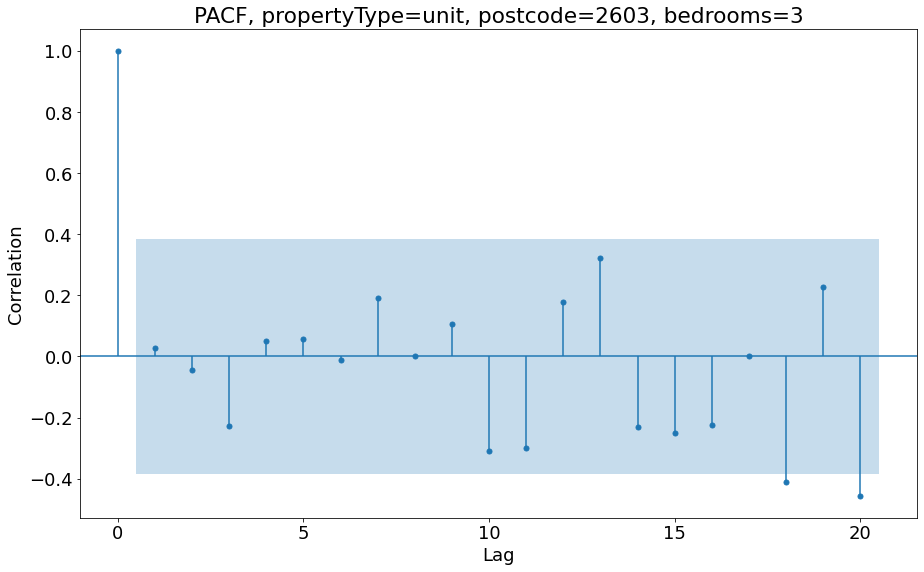

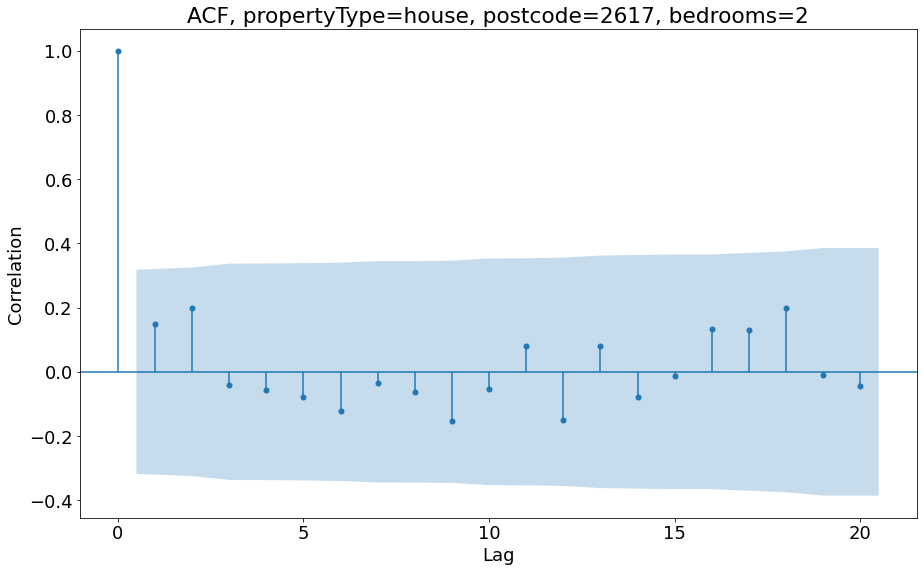

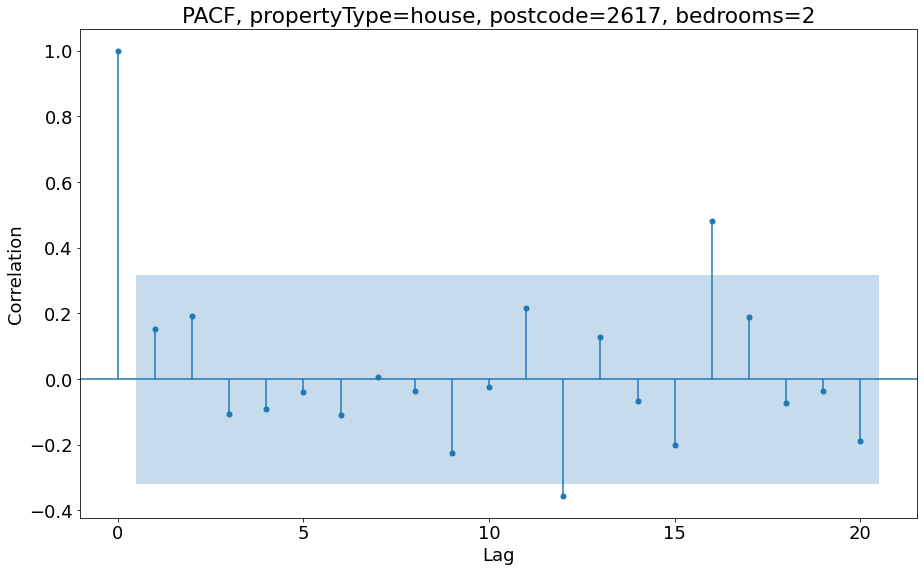

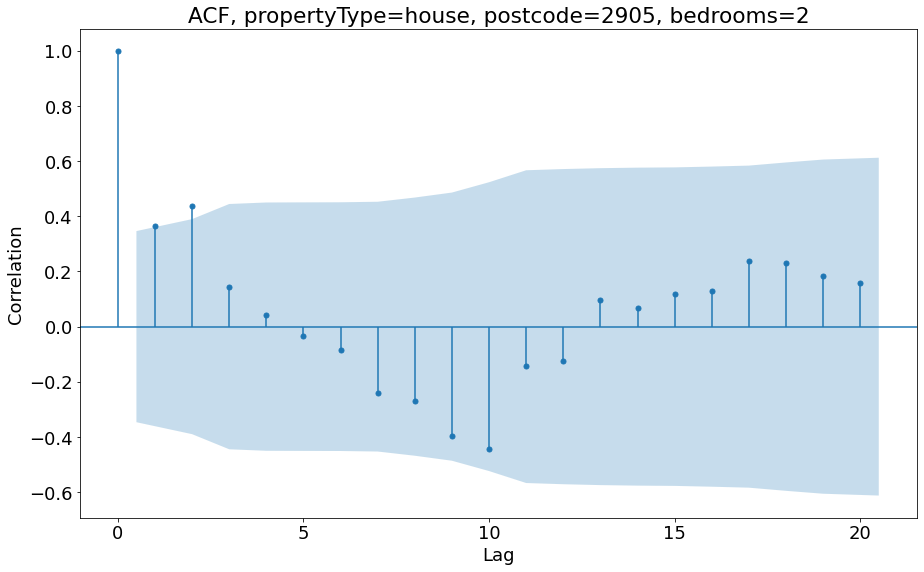

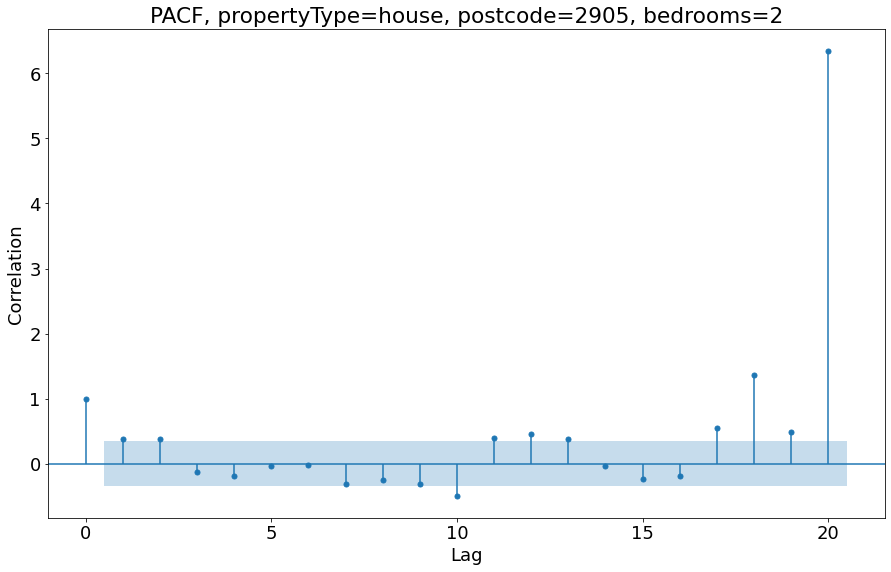

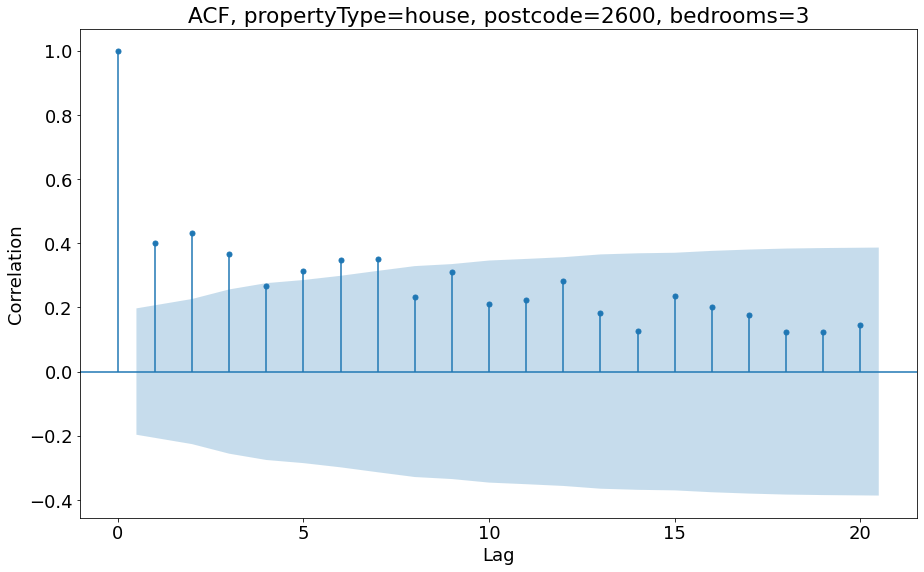

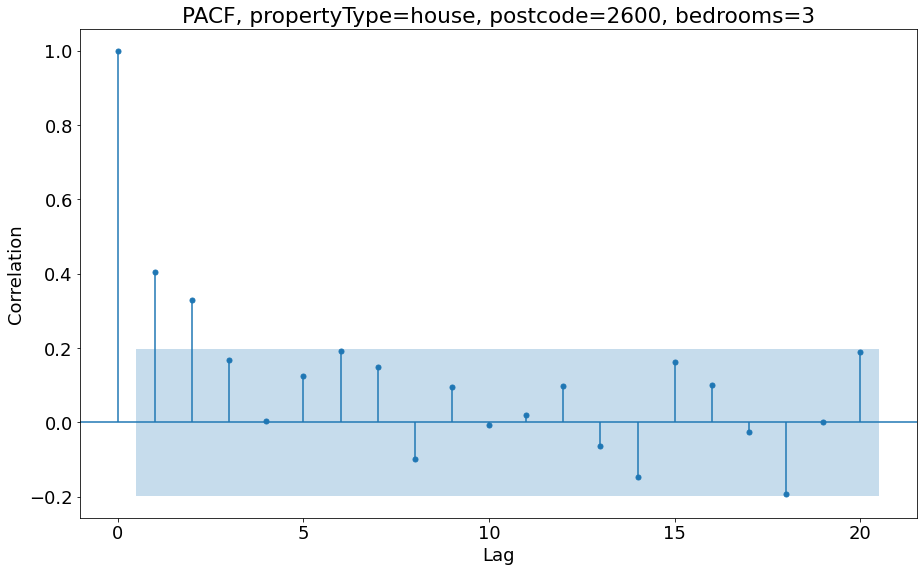

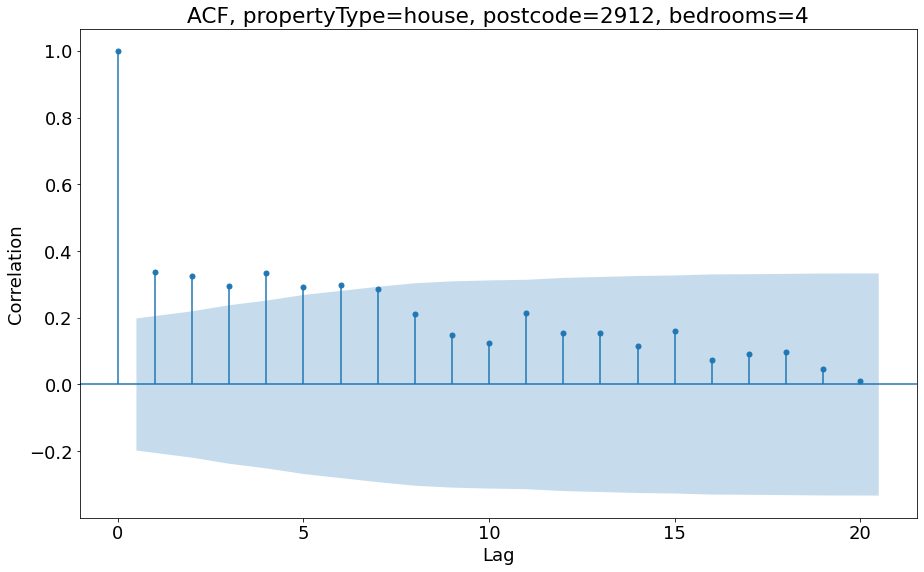

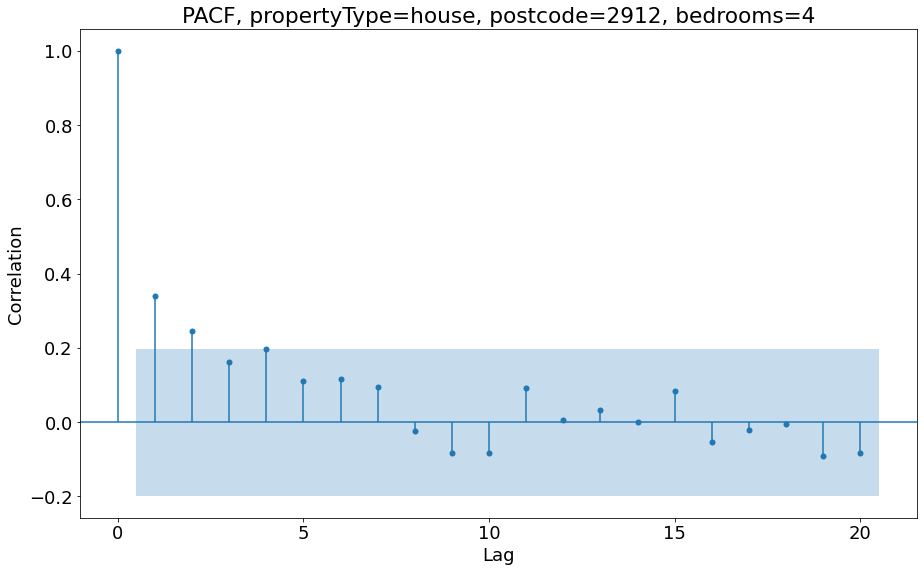

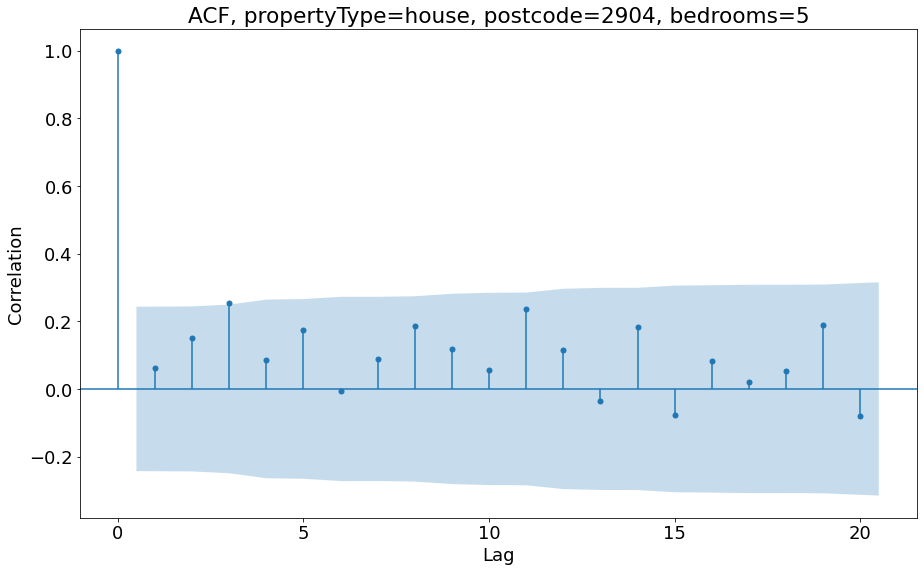

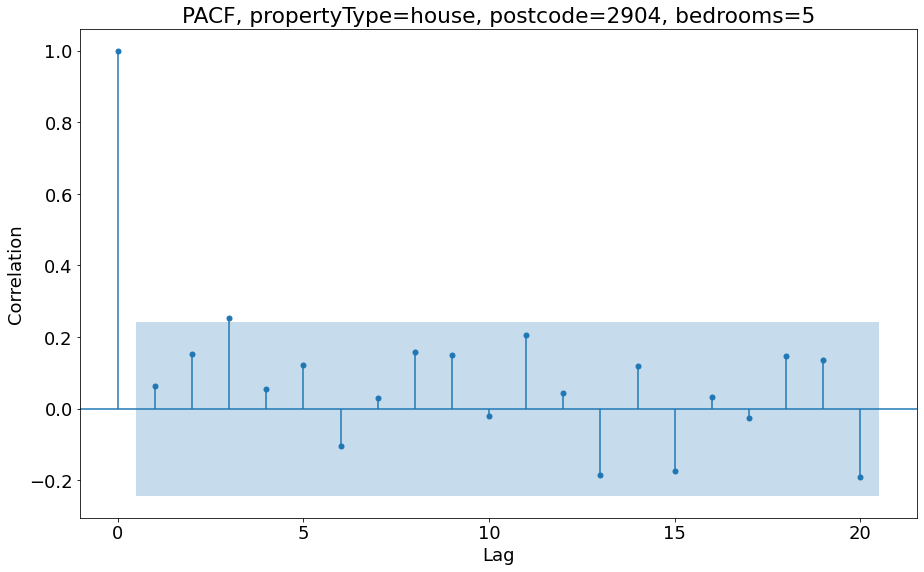

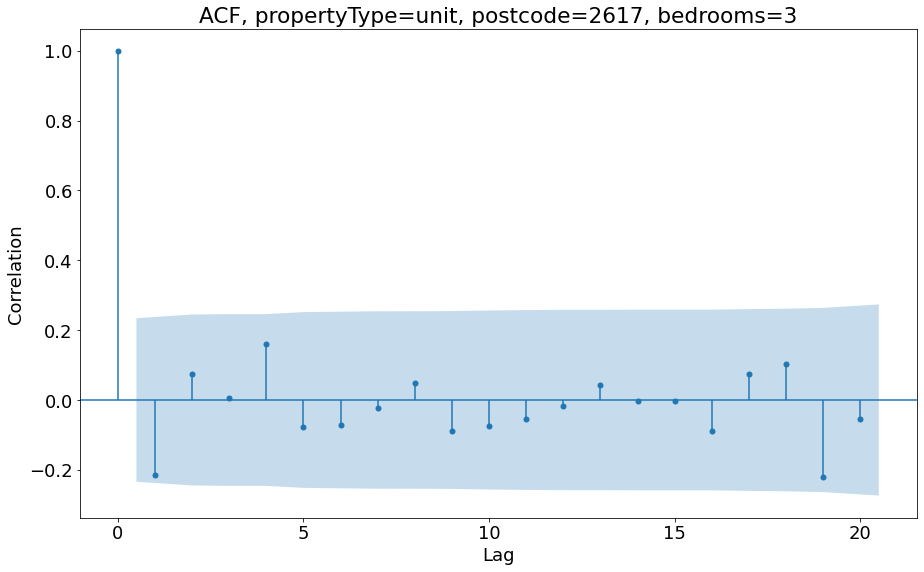

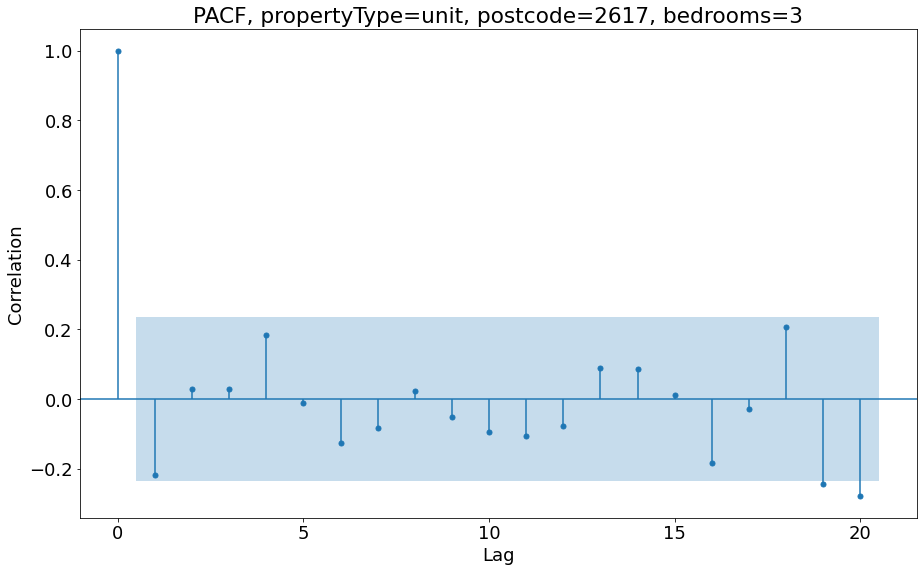

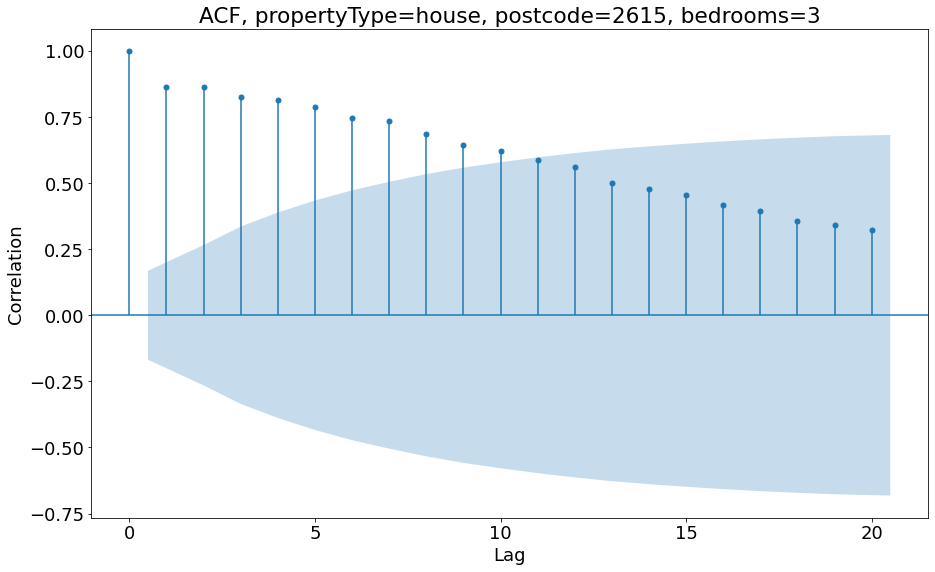

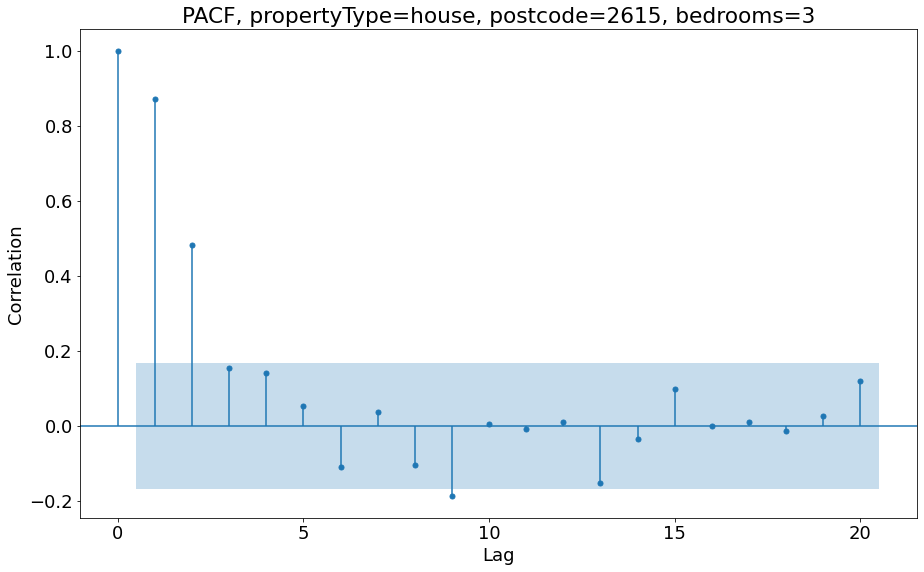

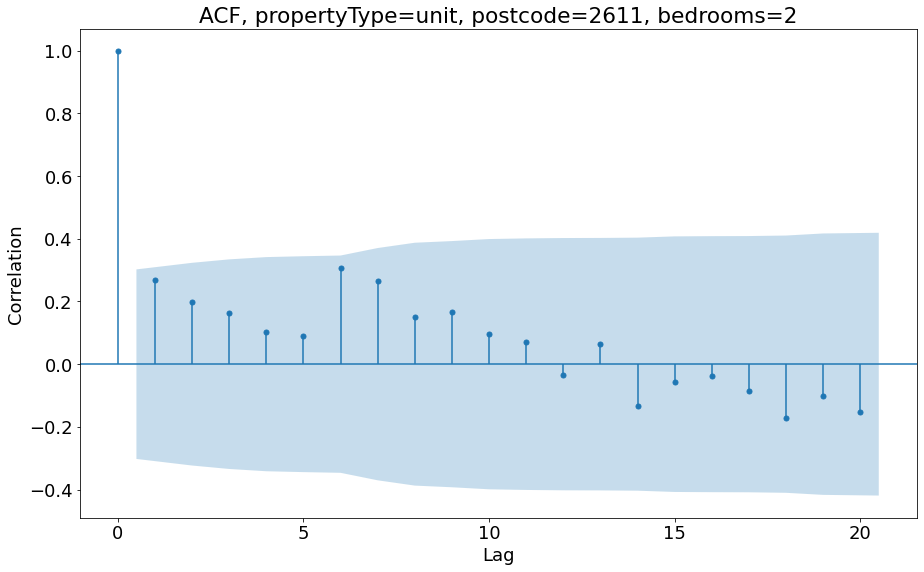

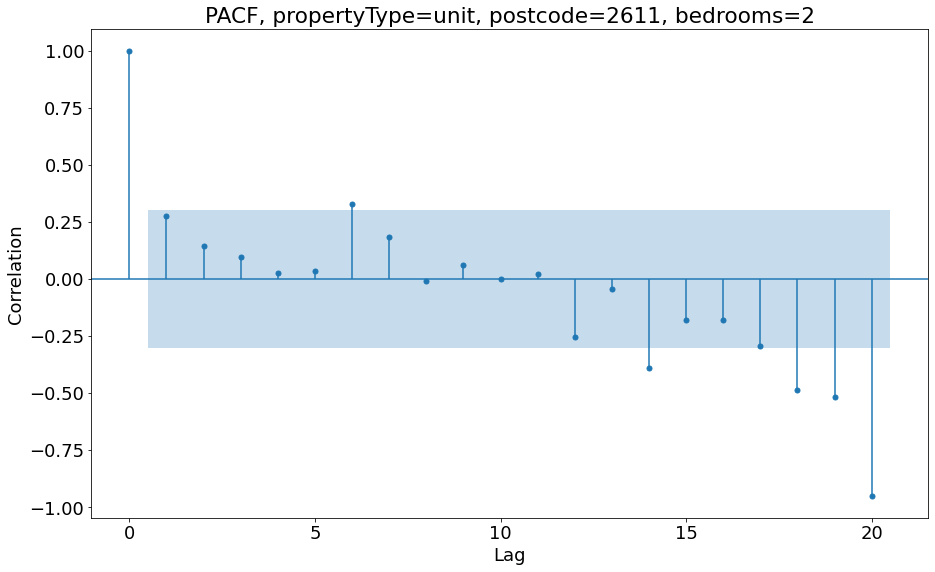

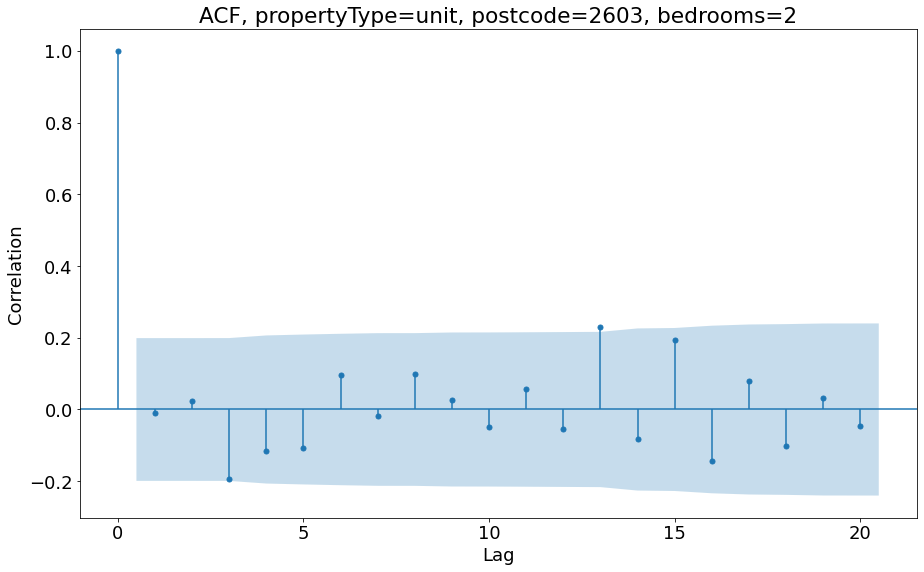

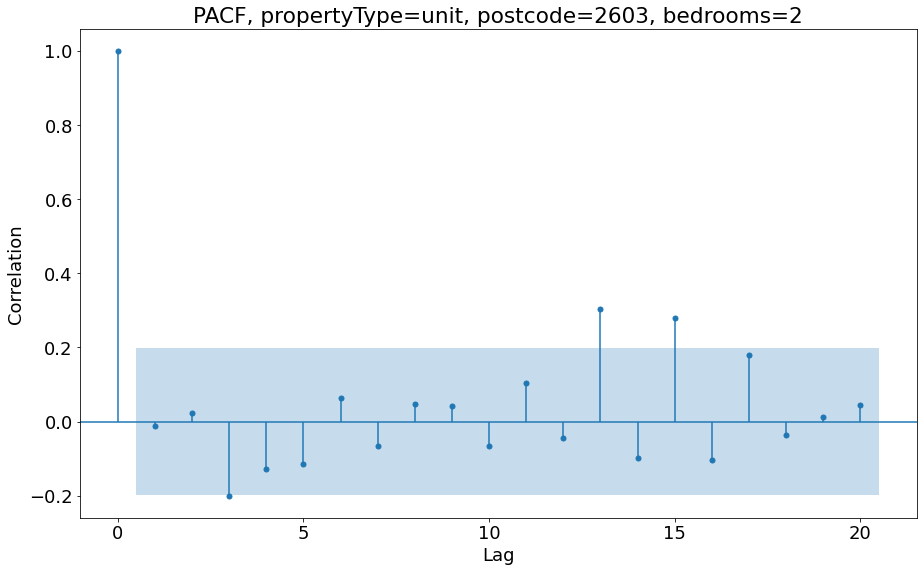

In [24]:
import statsmodels.api as sm
import datetime
df['month'] = df.index.month
df1 = df.groupby(['propertyType', 'bedrooms', 'datesold_year', 'month', 'postcode'])['price'].mean()
df1 = df1.reset_index()
df1['day'] = 1
df1['date'] = df1.apply(lambda x: datetime.date(x['datesold_year'], x['month'], x['day']), axis=1)
df1 = df1.sort_values('date')
df1 = df1.set_index('date')
df1 = df1.drop(['datesold_year', 'month', 'day'], axis=1)

propertyTypes = ['house', 'unit']
postcodes = list(set(df1.postcode.tolist()))
bedrooms = [1,2,3,4,5]

for i in range(40):
    
    property_type = np.random.choice(propertyTypes)
    postcode = np.random.choice(postcodes)
    bedroom = np.random.choice(bedrooms)
    df2 = df1.loc[(df1['propertyType'] == property_type) 
                  & (df1['postcode'] == postcode) 
                  & (df1['bedrooms'] == bedroom)]
    if len(df2) > 25:
        ax = sm.tsa.graphics.plot_acf(df2.price, lags=20)
        plt.title(f'ACF, propertyType={property_type}, postcode={postcode}, bedrooms={bedroom}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        ax = sm.tsa.graphics.plot_pacf(df2.price, lags=20)
        plt.title(f'PACF, propertyType={property_type}, postcode={postcode}, bedrooms={bedroom}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')

We see that results depend on the situation. By looking at the graphs, I can make some conclusions:

1) It definetely makes sense to take into account other features, rather than time. Since graphs of ACF and PACF depend on the group, the group itself can tell us a lot about the object

2) ACFs are mostly positive, while we cannot say the same about PACF

3) Correlations do not necessarly decrease with the higher lags, hence, there may be some kinds of complicated within-group seasonalities

4) Some correlations are quite big, thus, we should add lag features to our models

Now let's save our dataset to further work with it in later sections

In [25]:
df.to_csv('House_property_preprocessed.csv')

# References

1) Kaggle notebooks that were used for the same problem: 

https://www.kaggle.com/code/adrianograms/property-sales-raw-time-series-and-regression, 

https://www.kaggle.com/code/juminator/time-series-eda-for-beginners

2) https://machinelearningmastery.com/time-series-data-stationary-python/ - check if TS is stationary

3) https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf - PACF, ACF, and some useful staff